# Lhotse Shar

## Storage format optimized or sequential I/O and modularity

This notebook introduces and shows how to use Lhotse's own data storage format called Lhotse Shar.

### Similarities to WebDataset

Lhotse Shar is heavily inspired by the [WebDataset](https://github.com/webdataset/webdataset) project. Specifically, we borrow the concepts of 1) sequentially readable tar files, and 2) shards. Like WebDataset, we store the data itself in tar files for sequential reading, that are much faster to access than individual files or random-access storage formats. In fact, sequential reading often makes it feasible to train models when downloading the data over the network, e.g. from cloud storage services, with arbitrarily dataset sizes.

The scalability against dataset size is achieved using the second concept of WebDataset: sharding. Instead of writing the entire dataset into a single tar file, we would partition the data first into smaller chunks called shards. Each shard is then contained in a single tar file. At any given time, a single data loading worker would only read a single shard, but it may shuffle the shard order, as well as keep an internal buffer used for shuffling of data items across different shards. Since only a single time is read at any given time, the memory usage depends only on shuffling buffer size and does not depend on the dataset size.

Lhotse offers WebDataset integration to leverage the features described above. For a dedicated tutorial, see the notebook called `02-webdataset-integration.ipynb`.

### Features specific to Lhotse Shar

Lhotse WebDataset integration had a few shortcomings that made it frustrating to work with continuously evolving datasets. Specifically, when you need to compute various types of features for your data (think self-supervised representations, ASR posteriors, alignments, speaker embeddings, etc.) -- every time you compute them, or have a different version, you would have to create a new copy of your full dataset. Another downside was that the tarfile contained everything: the data itself (e.g., recording and features) and the metadata manifest (e.g., Cut manifest). In order to investigate the metadata, the user had to actually load or iterate through the entire shard; and editing the metadata required a full dataset copy again.

To address the beforementioned issues, we designed a modular format that allows to store the metadata, and each data field, in a separate sequentially-read file. For example, instead of having a single `shard-000000.tar` with metadata + audio + features, one would have:

```
tree data-shar
├── cuts.000000.jsonl.gz
├── fbank.000000.tar
├── recording.000000.tar
```

Upon reading, the user can iterate over the metadata only:

```
cuts = CutSet.from_shar(fields={"cuts": ["data-shar/cuts.000000.jsonl.gz"]})
```

Or the whole thing, or any combination of fields:

```
cuts_audio = CutSet.from_shar(
    fields={
        "cuts": ["data-shar/cuts.000000.jsonl.gz"],
        "recording": ["data-shar/recording.000000.tar"],
    },
)
cuts_feats = CutSet.from_shar(
    fields={
        "cuts": ["data-shar/cuts.000000.jsonl.gz"],
        "fbank": ["data-shar/fbank.000000.tar"],
    },
)
cuts_full = CutSet.from_shar(
    fields={
        "cuts": ["data-shar/cuts.000000.jsonl.gz"],
        "recording": ["data-shar/recording.000000.tar"],
        "fbank": ["data-shar/fbank.000000.tar"],
    },
)
```

When new type of data is computed, e.g., speaker embeddings, all it takes is to save them in yet another tar file, and specify it during reading.

Below, we'll showcase how to do this using mini librispeech to make it easy to reproduce.

```
from lhotse.shar import
```


In [18]:
# Optional auto-formatting

#!pip install nb_black
%load_ext lab_black

In [19]:
# Get the latest version of Lhotse, if not installed:

#!pip install git+https://github.com/lhotse-speech/lhotse

In [20]:
import os
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from lhotse import CutSet, Fbank
from lhotse.dataset import (
    DynamicBucketingSampler,
    K2SpeechRecognitionDataset,
    OnTheFlyFeatures,
    PerturbSpeed,
    PerturbVolume,
    SpecAugment,
    make_worker_init_fn,
)
from lhotse.shar import ArrayTarWriter, AudioTarWriter, JsonlShardWriter
from lhotse.recipes import (
    download_librispeech,
    prepare_librispeech,
)

In [21]:
root_dir = Path("data")
tmp_dir = Path("tmp")
tmp_dir.mkdir(exist_ok=True)
num_jobs = os.cpu_count() - 1

# (mini) LibriSpeech

We're downloading the data, preparing recording/supervision manfiests, and compiling them into CutSets. 
A cut is a basic "example" of data in Lhotse.

Approx. download size 450MB.

In [22]:
# libri_variant = "librispeech"
libri_variant = "mini_librispeech"
libri_root = download_librispeech(root_dir, dataset_parts=libri_variant)
libri = prepare_librispeech(
    libri_root, dataset_parts=libri_variant, output_dir=root_dir, num_jobs=num_jobs
)
cuts_train = CutSet.from_manifests(**libri["train-clean-5"]).trim_to_supervisions()
cuts_dev = CutSet.from_manifests(**libri["dev-clean-2"]).trim_to_supervisions()

Dataset parts:   0%|          | 0/2 [00:00<?, ?it/s]

Distributing tasks: 0it [00:00, ?it/s]

Processing:   0%|          | 0/1089 [00:00<?, ?it/s]

Distributing tasks: 0it [00:00, ?it/s]

Processing:   0%|          | 0/1519 [00:00<?, ?it/s]

# Export cuts to Lhotse Shar format

Sharding is a technique used to partition a large dataset into smaller parts that can be split between different GPU nodes and dataloading workers.

In this example, we're working with small data, but we'll treat it like a large dataset to illustrate the typical usage.

In [23]:
data_dir = tmp_dir / "data-shar"
data_dir.mkdir(parents=True, exist_ok=True)
shards = cuts_train.to_shar(data_dir, fields={"recording": "wav"}, shard_size=1000)
shards

{'cuts': ['tmp/data-shar/cuts.000000.jsonl.gz',
  'tmp/data-shar/cuts.000001.jsonl.gz'],
 'recording': ['tmp/data-shar/recording.000000.tar',
  'tmp/data-shar/recording.000001.tar']}

In [24]:
!tree {data_dir}

tmp/data-shar
├── cuts.000000.jsonl.gz
├── cuts.000001.jsonl.gz
├── fbank.000000.tar
├── fbank.000001.tar
├── recording.000000.tar
└── recording.000001.tar

1 directory, 6 files


# Read cuts from Lhotse Shar format

We're going to read the CutSet in two variants: the first only contains the metadata, and the other ones allows to access the audio data as well.

In [25]:
cuts_nodata = CutSet.from_shar(fields={"cuts": shards["cuts"]})
cuts_audio = CutSet.from_shar(fields=shards)

In [26]:
print("Metadata only:", cuts_nodata[0].recording)
print("With audio data:", cuts_audio[0].recording)

Metadata only: Recording(id='32-21631-0000', sources=[AudioSource(type='shar', channels=[0], source='')], sampling_rate=16000, num_samples=260000, duration=16.25, channel_ids=[0], transforms=None)
With audio data: Recording(id='32-21631-0000', sources=[AudioSource(type='memory', channels=[0], source='<binary-data>')], sampling_rate=16000, num_samples=260000, duration=16.25, channel_ids=[0], transforms=None)


In [27]:
# Reading audio works as usual here.
cuts_audio[0].load_audio()

array([[0.00167847, 0.00115967, 0.00164795, ..., 0.0050354 , 0.00344849,
        0.00057983]], dtype=float32)

In [28]:
import traceback

# This one will raise an exception -- the metadata indicates there is a recording for this Cut,
# but we did not actually load it.
try:
    cuts_nodata[0].load_audio()
except:
    traceback.print_exc()

Traceback (most recent call last):
  File "/Users/pzelasko/meaning/lhotse/lhotse/utils.py", line 757, in wrapper
    return fn(*args, **kwargs)
  File "/Users/pzelasko/meaning/lhotse/lhotse/audio.py", line 571, in load_audio
    samples = source.load_audio(
  File "/Users/pzelasko/meaning/lhotse/lhotse/audio.py", line 200, in load_audio
    raise RuntimeError(
RuntimeError: Inconsistent state: found an AudioSource with Lhotse Shar placeholder that was not filled during deserialization.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/pzelasko/meaning/lhotse/lhotse/utils.py", line 757, in wrapper
    return fn(*args, **kwargs)
  File "/Users/pzelasko/meaning/lhotse/lhotse/cut/mono.py", line 75, in load_audio
    return self.recording.load_audio(
  File "/Users/pzelasko/meaning/lhotse/lhotse/utils.py", line 759, in wrapper
    raise type(e)(
RuntimeError: Inconsistent state: found an AudioSource with Lhotse Shar place

# Extend Lhotse Shar data directory with fbank features

Note: this is for illustration purposes, as we might add a special method in Lhotse that roughly wraps the code below. Specifically, we could replace Fbank here with something like a neural network and save its embeddings or outputs instead, under some different name.

In [29]:
fbank = Fbank()

# ArrayTarWriter detects the %06d formatting pattern and will auto-increment the shard number.
with ArrayTarWriter(
    f"{data_dir}/fbank.%06d.tar", shard_size=1000, compression="lilcom"
) as writer:
    for cut in cuts_audio:

        # `feats` is a numpy array with log Mel filter bank features.
        feats = cut.compute_features(fbank)

        # `cut` now contains a field `cut.fbank` with metadata manifest for the features,
        # and a method `cut.load_fbank()` that loads the features (respects pad/truncation).
        cut = cut.attach_tensor(
            "fbank", feats, frame_shift=fbank.frame_shift, temporal_dim=0
        )

        # We store the features under key `cut.id`, because during loading we'll check that the IDs match
        # to avoid data errors. We also store the feature manifest to have some information about this data.
        writer.write(cut.id, feats, cut.fbank)

feature_shards = writer.output_paths

Now, we'll notice that ``data_dir`` contains new files corresponding to fbank features:

In [30]:
!tree {data_dir}

tmp/data-shar
├── cuts.000000.jsonl.gz
├── cuts.000001.jsonl.gz
├── fbank.000000.tar
├── fbank.000001.tar
├── recording.000000.tar
└── recording.000001.tar

1 directory, 6 files


And these features can be easily read together with the rest of the data:

In [31]:
cuts_audio_feat = CutSet.from_shar(
    fields={
        "cuts": shards["cuts"],
        "recording": shards["recording"],
        "fbank": feature_shards,
    }
)

In [32]:
print("Audio array:", cuts_audio_feat[0].load_audio())
print("Fbank array:", cuts_audio_feat[0].load_fbank())

Audio array: [[0.00167847 0.00115967 0.00164795 ... 0.0050354  0.00344849 0.00057983]]
Fbank array: [[-12.        -11.140625  -12.432556  ...  -6.771435   -8.434268
   -8.622934 ]
 [-12.03125   -11.44873   -12.731472  ...  -7.764103   -8.19296
   -8.277521 ]
 [-11.780518  -11.445381  -13.427237  ...  -8.157727   -7.7074375
   -7.68688  ]
 ...
 [-12.564316  -11.222908  -11.478207  ...  -6.5719357  -6.856142
   -6.995369 ]
 [-13.957339  -13.062187  -13.48411   ...  -7.526575   -6.732027
   -6.9562626]
 [-13.723964  -13.160282  -12.856873  ...  -7.112692   -7.3774586
   -7.6607056]]


# Training DataLoader with Lhotse Shar

### Shards, multi-GPU, and avoiding data duplication

Lhotse Shar requires a few adjustments to the DataLoader initialization as compared to a vanilla Lhotse workflow.
Note that in a multi-GPU and multi-dataloader-worker setting, all processes see the same CutSet with the same list of shards.
A common solution to this problem is to split the shard list across different workers so that each worker sees a non-overlapping subset.
However, we found in practice that this is not necessary.
Given enough shards, all it takes is to shuffle them differently in each process/worker, and keep re-shuffling as the full epoch is reached.
Even with medium sized datasets, it is extremely unlikely that two workers would yield mini-batches containing duplicated data.
In order to re-shuffle the shard order on each epoch, we expect the CutSet will be made (infinitely) repeated using `cuts = cuts.repeat()`.

### Comparison to vanilla Lhotse dataloading and Lhotse+WebDataset dataloading

We'll extend the "base" approach used in `examples/00-basic-workflow.ipynb` (next to this file).
The code below has the same functionality, just reads the data differently.
It is also very similar to the workflow in `examples/02-webdataset-integration.ipynb`.

### Implementation note: the use of IterableDataset

We require the use of IterableDataset, which in our case is just a wrapper over sampler iteration and map-style dataset that converts CutSet mini-batch to tensors.
What this does is it moves the sampler to dataloading worker processes, so Lhotse Shar can "auto-detect" that its in a multi-worker context and can drop some shards in each worker/node. Remember that in a "typical" sampler + map-style dataset scenario, the sampler lives in the same process as the main training loop instead.

To learn more about map-style and iterable-style datasets, see: https://pytorch.org/docs/stable/data.html#dataset-types

In [34]:
cuts = CutSet.from_shar(
    fields={
        "cuts": shards["cuts"],
        "recording": shards["recording"],
    },
    # The three arguments below are specifically for dataloading.
    # shuffle_shards=True enables shuffling of shards,
    # stateful_shuffle=True makes the shuffling different on each epoch,
    # and seed="randomized" tells the CutSet to randomize the seed on each dataloader node and worker.
    shuffle_shards=True,
    stateful_shuffle=True,
    seed="randomized",
).repeat()  # repeat() enables the stateful shuffling

train_sampler = DynamicBucketingSampler(
    cuts,
    shuffle=True,
    max_duration=100.0,
    num_buckets=10,
    rank=0,
    world_size=1,
)

train_dataset = K2SpeechRecognitionDataset(
    cut_transforms=[
        PerturbSpeed(factors=[0.9, 1.1], p=2 / 3),
        PerturbVolume(scale_low=0.125, scale_high=2.0, p=0.5),
    ],
    input_transforms=[
        SpecAugment(),  # default configuration is well-tuned
    ],
    input_strategy=OnTheFlyFeatures(Fbank()),
)

# This is the part that's different:
from lhotse.dataset.iterable_dataset import IterableDatasetWrapper

train_iter_dataset = IterableDatasetWrapper(
    dataset=train_dataset,
    sampler=train_sampler,
)

train_dloader = DataLoader(
    train_iter_dataset,
    batch_size=None,
    # For faster dataloading, use num_workers > 1
    num_workers=2,
    # Note: Lhotse offers its own "worker_init_fn" that helps properly
    #       set the random seeds in all workers (also with multi-node training)
    #       and randomizes the shard order across different workers.
    worker_init_fn=make_worker_init_fn(),
)

### Visualisation

We simply iterate the dataloader as usual and view how the first batch looks like

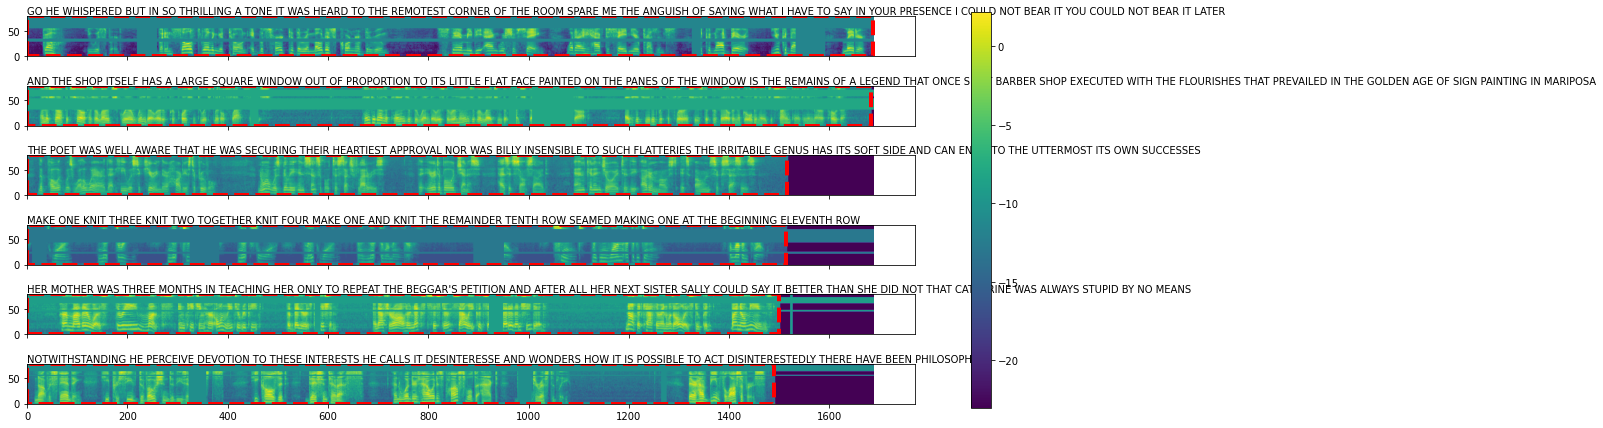

In [35]:
from lhotse.dataset.vis import plot_batch

for batch in train_dloader:
    plot_batch(batch)
    break